# Topic Classification of Trustpilot Reviews
#### In this Jupyter Notebook, we will explore the task of topic classification for Trustpilot reviews.The reviews can range from positive to negative given the rating between 1-5 stars, and they often contain valuable insights about customer experiences.
 
#### Topic classification is the process of automatically categorizing a given text into one or more predefined topics. It can be a useful technique for analyzing large amounts of text data and identifying patterns and trends. In the case of Trustpilot reviews, topic classification can help businesses and service providers better understand their customers' feedback and address any issues or concerns.

#### In this notebook, we will use natural language processing techniques and machine learning algorithms to classify Trustpilot reviews into different topics. 

#### By the end of this notebook, we should have a given a good understanding of how to perform topic classification on Trustpilot reviews and how to apply these techniques to other text classification tasks.

In [1]:
import pickle
from functools import partial
from string import punctuation

import dacy # needed for stopwords
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

import fetch
from fetch.utils import json_or_fetch

## The first thing we do is scrape trustpilot delivery companies: 
#### Postnord, Fedex & UPS. and putting them into a DataFrame with: Title, body and rating.

In [2]:
many_pages = partial(fetch.trustpilot, page_limit=100)

In [3]:
urls = ['https://dk.trustpilot.com/review/www.postnord.dk', 'https://dk.trustpilot.com/review/www.fedex.com', 'https://dk.trustpilot.com/review/www.ups.com']
args = tuple(zip(urls))

In [4]:
reviews_dict = json_or_fetch(many_pages, urls, args, path='Data/trustpilot.json', reload=True)

https://dk.trustpilot.com/review/www.postnord.dk: 2000 reviews from 100 pages. There are more pages left.
https://dk.trustpilot.com/review/www.fedex.com: 249 reviews from 13 pages.
https://dk.trustpilot.com/review/www.ups.com: 1121 reviews from 57 pages.


In [5]:
reviews = []
for company_reviews in reviews_dict.values():
    reviews.extend(company_reviews)

In [6]:
df = pd.DataFrame(reviews)
df.head()

,company,title,body,rating
0,PostNord i Danmark,Tjekker ikke modtagerflex,Pakken blev sat foran min hoveddør (med risiko...,1
1,PostNord i Danmark,En seriøst Postmand smider ikke en…,En seriøst Postmand smider ikke en pakke på 10...,1
2,PostNord i Danmark,2 pakker forsvundet på én uge,2 pakker har Post Nord formået at lade forsvin...,1
3,PostNord i Danmark,Langsomt og ansvarløst,Langsomt og ansvarløstEfter at have klaget ove...,1
4,PostNord i Danmark,Leveret til forkert posthus. Ingen info,Leveret til forkert posthus. Det er altid en s...,1


#### We are using count to return the number of non-null values for each column of the DataFrame 

In [7]:
df.count()

company    3370
title      3370
body       2515
rating     3370
dtype: int64

#### We are using .info to that provides a summary of the DataFrame df, including the number of non-null values, the data type of each column, and memory usage.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   company  3370 non-null   object
 1   title    3370 non-null   object
 2   body     2515 non-null   object
 3   rating   3370 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 105.4+ KB


####  Here we check if any of the value in the df is NaN

In [9]:
df.isna().sum()

company      0
title        0
body       855
rating       0
dtype: int64

Find the indices of the rows without a `body` value to inspect them.

In [10]:
body_na = df['body'].isna()

In [11]:
df[body_na].head()

,company,title,body,rating
79,PostNord i Danmark,Hurtigt og nemt leveret lige til døren.,None,5
80,PostNord i Danmark,Blev leveret 4 dage senere end lovet,None,2
86,PostNord i Danmark,Pakken blev leveret til døren.,None,4
90,PostNord i Danmark,Pakken var stillet diskret i garagen,None,5
91,PostNord i Danmark,Glad og tilfreds med leveringen,None,5


#### We here give the NaN values the title data instead

In [12]:
df['body'].fillna(df['title'], inplace=True)

We no longer have missing values.

In [13]:
df.count()

company    3370
title      3370
body       3370
rating     3370
dtype: int64

In [14]:
df.isna().sum()

company    0
title      0
body       0
rating     0
dtype: int64

Double-check to see that the replacement was succesful and didn't affect anything else.

In [15]:
df[body_na].head()

,company,title,body,rating
79,PostNord i Danmark,Hurtigt og nemt leveret lige til døren.,Hurtigt og nemt leveret lige til døren.,5
80,PostNord i Danmark,Blev leveret 4 dage senere end lovet,Blev leveret 4 dage senere end lovet,2
86,PostNord i Danmark,Pakken blev leveret til døren.,Pakken blev leveret til døren.,4
90,PostNord i Danmark,Pakken var stillet diskret i garagen,Pakken var stillet diskret i garagen,5
91,PostNord i Danmark,Glad og tilfreds med leveringen,Glad og tilfreds med leveringen,5


In [16]:
df.head()

,company,title,body,rating
0,PostNord i Danmark,Tjekker ikke modtagerflex,Pakken blev sat foran min hoveddør (med risiko...,1
1,PostNord i Danmark,En seriøst Postmand smider ikke en…,En seriøst Postmand smider ikke en pakke på 10...,1
2,PostNord i Danmark,2 pakker forsvundet på én uge,2 pakker har Post Nord formået at lade forsvin...,1
3,PostNord i Danmark,Langsomt og ansvarløst,Langsomt og ansvarløstEfter at have klaget ove...,1
4,PostNord i Danmark,Leveret til forkert posthus. Ingen info,Leveret til forkert posthus. Det er altid en s...,1


In [17]:
# df.groupby('rating').count()
df.groupby('rating').size()

rating
1    1366
2     112
3      79
4     192
5    1621
dtype: int64

### Here comes an overview of the different rating and how the reviews rating are given
#### Y shows us the amount of review
#### X shows us the rating 1,2,3,4 or 5

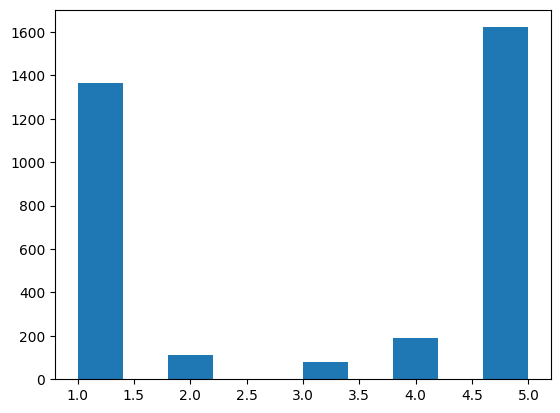

In [18]:
plt.hist(df['rating'])
plt.show()

##### Binning ratings into sentiment categories so we can compare with results of pretrained sentiment analysis models.
#### 1-2 is negative
#### 3 is neutral
#### 4-5 is postive

In [19]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

In [20]:
df['sentiment'] = df['rating'].apply(rating_to_sentiment)

#### We can now make a groupby and check how the reviews are sorted into the different sentiments, postive,negative and neutral

In [21]:
sentiment_distribution = df.groupby('sentiment').size()
sentiment_distribution

sentiment
negative    1478
neutral       79
positive    1813
dtype: int64

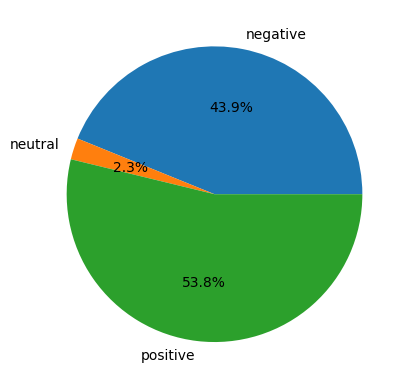

In [22]:
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%')
plt.show()

In [23]:
df.to_csv('Data/trustpilot.csv', index=False)

In [24]:
docs = df['body'].tolist()

## Stopwords and text cleaning

#### todo bruger vi dette step
Cleaning? Nej. count_vectorizer bruges til at fjerne stopwords i Bertopic.

In [25]:
# da_stopwords = nltk.corpus.stopwords.words('danish')
da_stopwords = spacy.lang.da.stop_words.STOP_WORDS

In [26]:
type(da_stopwords)

set

In [27]:
count_vectorizer = CountVectorizer(stop_words=list(da_stopwords))

In [28]:
def clean_sentence(sentence):
    sentence = sentence.strip()
    words = nltk.word_tokenize(sentence, language='danish')
    words = [word for word in words if word.lower() not in da_stopwords and word not in punctuation]
    return ' '.join(words)

In [29]:
# docs = [clean_sentence(doc) for doc in docs]

## Embeddings

In this part we are working with embeddings, which essentialy is a numerical representation of words and sentences. These representations are created by training our deep learning model BERTopic on large text corpora, where the models learn to encode the meaning of words and phrases into a vector space.

The vector space created by the embedding model has the property that words with similar meanings are located close to each other. This allows us to perform various natural language processing (NLP) tasks, such as text classification, clustering, and retrieval, by using the distance or similarity between the embeddings.

In our example, we use the SentenceTransformer library to generate sentence embeddings. Specifically, we use the 'paraphrase-multilingual-MiniLM-L12-v2' pre-trained model, which is a transformer-based model that has been trained on a large corpus of text in multiple languages.

By using the 'paraphrase-multilingual-MiniLM-L12-v2' embedder, we can encode each sentence in our dataset into a vector representation, which can then be used as input to machine learning algorithms for typical tasks such as text classification or clustering.

In [30]:
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [31]:
embeddings = embedder.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [32]:
embeddings.shape

(3370, 384)

## Bertopic model

##### Language: "multilingual", indicating that the model can handle multiple languages.
##### Nr_topics: None, which means that the number of topics will be determined automatically by the model.
##### Min_topic_size: 5, which sets the minimum number of documents a topic must have to be considered a valid topic.
##### Vectorizer_model: count_vectorizer, which specifies the vectorizer model to use for text preprocessing.
##### Seed_topic_list: [['god', 'godt', 'hurtig', 'hurtigt'], ['dårlig', 'dårligt', 'dårlige', 'langsom']], which sets the initial topics to start the topic modeling process. These are the topics that the model will use as a starting point to identify other related topics.

In [33]:
ctfid_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [34]:
topic_model = BERTopic(language="multilingual", nr_topics=None, min_topic_size=5, vectorizer_model=count_vectorizer,
                       seed_topic_list=[['god', 'godt', 'hurtig', 'hurtigt'],
                                        ['dårlig', 'dårligt', 'dårlige', 'langsom']])

In [35]:
topics, probs = topic_model.fit_transform(docs, embeddings)

In [36]:
topic_model.get_topic_info()[:20]

,Topic,Count,Name
0,-1,395,-1_hurtig_hurtigt_levering_tiden
1,0,1687,0_ups_pakke_pakken_hjemme
2,1,78,1_hurtig_levering__
3,2,70,2_fedex_pakke_pakken_kundenummer
4,3,43,3_hurtig_levering_forsendelse_
5,4,43,4_hurtig_levering_fin_herfra
6,5,35,5_postmand_venlig_flink_post
7,6,34,6_hurtig_levering_præsis_fest
8,7,30,7_fin_levering_præcis_lovet
9,8,30,8_hurtigt_præcis_hurtig_præcist




I think the actual problem is just having way too few documents for it extract topics.

Decreasing `min_topic_size` helped.

## Visualizations of the topic modeling's results, with different visulization representations

In [37]:
topic_model.visualize_barchart()

The topics don't seem to allign greatly with sentiment just from looking at the keywords.

In [38]:
topic_model.visualize_topics(top_n_topics=20)

In [39]:
topic_model.visualize_documents(docs, embeddings=embeddings, hide_annotations=True)

#### Visual representation of the data
We can see that many of reviews goes into the topic -1 which is not ideal

In [40]:
dfTopic = topic_model.get_topic_info()[:20]

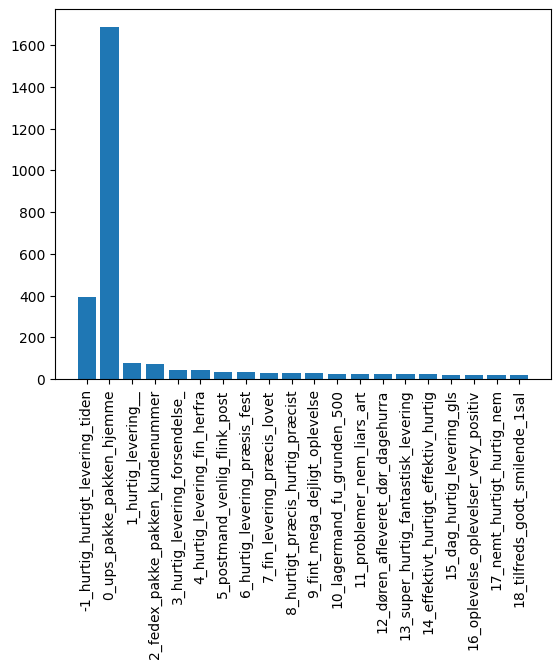

In [41]:
plt.bar(dfTopic['Name'], dfTopic['Count'])
plt.xticks(rotation=90)
plt.show()

Let's save the model for later use.

In [42]:
with open('Models/bertopic.pkl', 'wb') as f:
    pickle.dump(topic_model, f)